In [33]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [34]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"

INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [35]:
if should_load_sisfall_data is True:
    raw_sisfall_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)

    raw_sisfall_dataset.to_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")
else:
    raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [37]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files


uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity13','Activity14','Activity15'])

raw_uma_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

raw_uma_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
raw_uma_df

,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
0,0.220,0.930664,0.061279,0.353027,15,14,1,0
1,0.244,0.932373,0.127197,0.355957,15,14,1,0
2,0.260,0.932373,0.127197,0.355957,15,14,1,0
3,0.280,0.935791,0.060791,0.360352,15,14,1,0
4,0.293,0.935791,0.060791,0.360352,15,14,1,0
...,...,...,...,...,...,...,...,...
82692,14.872,-1.05127,-0.065918,0.307373,9,1,2,0
82693,14.892,-1.05127,-0.065918,0.307373,9,1,2,0
82694,14.913,-0.96582,0.075195,0.362549,9,1,2,0
82695,14.934,-0.96582,0.075195,0.362549,9,1,2,0


In [38]:
grouped_data = []


combined_df_sorted = raw_uma_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                # 'group_id': group_id,
                'data': sensor_data,
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'data': sensor_data,
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())


if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'data': sensor_data,
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_raw_dataset = pd.DataFrame(grouped_data)
uma_raw_dataset


,subject,activity,trial,data
0,1,D1,1,acc_x acc_y acc_z 0 -0.74023...
1,1,D1,2,acc_x acc_y acc_z 0 -0.76416...
2,1,D1,3,acc_x acc_y acc_z 0 -0.75732...
3,2,D1,1,acc_x acc_y acc_z 0 -0.95336...
4,2,D1,2,acc_x acc_y acc_z 0 -0.96289...
...,...,...,...,...
276,19,D15,2,acc_x acc_y acc_z 0 -1.02294...
277,19,D15,3,acc_x acc_y acc_z 0 -1.37255...
278,19,D15,4,acc_x acc_y acc_z 0 -0.92089...
279,19,D15,5,acc_x acc_y acc_z 0 -0.90795...


In [79]:
uma_raw_dataset['data'][0]

,acc_x,acc_y,acc_z
0,-0.740234,0.571289,0.249512
1,-0.842285,0.598145,0.297119
2,-0.833252,0.425781,0.332031
3,-0.721191,0.518311,0.116455
4,-0.741699,0.651611,0.380127
...,...,...,...
280,-0.878662,0.503418,0.118896
281,-0.760742,0.463623,0.170898
282,-0.702393,0.350342,0.258301
283,-0.600098,0.412842,0.168457


In [39]:
UMA_ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02', 'D1'],  
    'jogging': ['D03', 'D04', 'D2'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11", "F12", "F13", "F14", "F15", 'D13', 'D14', 'D15'],
    # 'stairs': ["D5", "D6"]
}

# Create a function to map activity codes to class names
def map_activity_to_class(activity_code):
    for class_name, codes in UMA_ACTIVITY_CLASSES.items():
        if activity_code in codes:
            return class_name
    return 'unknown'

# Apply the mapping function to update the activity column
uma_raw_dataset['activity'] = uma_raw_dataset['activity'].apply(lambda x: f"D{x}" if isinstance(x, int) else x)
uma_raw_dataset['activity'] = uma_raw_dataset['activity'].apply(map_activity_to_class)

In [40]:
uma_raw_dataset['activity'].value_counts()

activity
fall       198
walking     55
jogging     28
Name: count, dtype: int64

In [41]:
uma_raw_dataset.drop(columns=['subject', 'trial'], inplace=True)

In [42]:
uma_raw_dataset

,activity,data
0,walking,acc_x acc_y acc_z 0 -0.74023...
1,walking,acc_x acc_y acc_z 0 -0.76416...
2,walking,acc_x acc_y acc_z 0 -0.75732...
3,walking,acc_x acc_y acc_z 0 -0.95336...
4,walking,acc_x acc_y acc_z 0 -0.96289...
...,...,...
276,fall,acc_x acc_y acc_z 0 -1.02294...
277,fall,acc_x acc_y acc_z 0 -1.37255...
278,fall,acc_x acc_y acc_z 0 -0.92089...
279,fall,acc_x acc_y acc_z 0 -0.90795...


In [ ]:
import itertools
import numpy as np


def extract_features_advanced(data, with_magnitude=True):
    data = data.copy()
    # Clean and ensure all data is numeric
    for col in data.columns:
        data[col] = data[col].astype(str)
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.fillna(0)

    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")
        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0   

    # Assume data has columns: ax, ay, az (accelerometer data)
    # Extract original acceleration components
    if 'acc_x' in data.columns and 'acc_y' in data.columns and 'acc_z' in data.columns:
        ax = data['acc_x'].values
        ay = data['acc_y'].values  
        az = data['acc_z'].values
    else:
        # If columns are named differently, use first 3 columns
        ax = data.iloc[:, 0].values
        ay = data.iloc[:, 1].values
        az = data.iloc[:, 2].values

    # Add magnitude features if requested
    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:   
                slice_ = data.iloc[:, i:i+3]
                magnitude = np.linalg.norm(slice_, axis=1)
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                data[name] = magnitude

    # Calculate the new accelerometer-based features from the table
    additional_features = {}
    
    # C1: Sum vector magnitude (RMS)
    c1 = np.sqrt(np.mean(ax**2 + ay**2 + az**2))
    additional_features['C1_sum_vector_magnitude'] = c1
    
    # C2: Sum vector magnitude on horizontal plane
    c2 = np.sqrt(np.mean(ax**2 + az**2))
    additional_features['C2_horizontal_magnitude'] = c2
    
    # C3: Maximum peak-to-peak acceleration amplitude
    c3_x = np.max(ax) - np.min(ax)
    c3_y = np.max(ay) - np.min(ay) 
    c3_z = np.max(az) - np.min(az)
    c3 = np.sqrt(c3_x**2 + c3_y**2 + c3_z**2)
    additional_features['C3_max_peak_to_peak'] = c3
    
    # C4: Angle between z-axis and vertical
    c4 = np.arctan2(np.sqrt(ax**2 + az**2), -ay)
    additional_features['C4_z_axis_vertical_angle'] = np.mean(c4)
    
    # C5: Orientation of person's trunk
    rms_xz = np.sqrt(np.mean(ax**2 + az**2))
    c5 = np.arctan(rms_xz / np.mean(np.abs(ay)))
    additional_features['C5_trunk_orientation'] = c5
    
    # C6: Orientation change in horizontal plane (using moving average)
    N = min(10, len(ax)//4)  # Window size
    if N > 0:
        ax_delayed = np.roll(ax, N)
        c6 = np.mean(ax_delayed * ax)  # Simplified version
        additional_features['C6_horizontal_orientation_change'] = c6
    else:
        additional_features['C6_horizontal_orientation_change'] = 0
    
    # C7: Jerk (rate of acceleration change)
    if len(ax) > 1:
        dt = 1  # Assuming unit time steps
        jerk_x = np.diff(ax) / dt
        c7 = np.mean(np.abs(jerk_x))
        additional_features['C7_jerk'] = c7
    else:
        additional_features['C7_jerk'] = 0
    
    # C8: Standard deviation magnitude on horizontal plane
    std_x = np.std(ax)
    std_z = np.std(az)
    c8 = np.sqrt(std_x**2 + std_z**2)
    additional_features['C8_std_horizontal'] = c8
    
    # C9: Standard deviation magnitude
    std_y = np.std(ay)
    c9 = np.sqrt(std_x**2 + std_y**2 + std_z**2)
    additional_features['C9_std_magnitude'] = c9
    
    # C10: Signal magnitude area
    c10 = (np.sum(np.abs(ax)) + np.sum(np.abs(ay)) + np.sum(np.abs(az))) / len(ax)
    additional_features['C10_signal_magnitude_area'] = c10
    
    # C11: Signal magnitude area on horizontal plane
    c11 = (np.sum(np.abs(ax)) + np.sum(np.abs(az))) / len(ax)
    additional_features['C11_horizontal_signal_area'] = c11
    
    # C12: Activity signal magnitude area (integral of magnitude over time)
    magnitude_3d = np.sqrt(ax**2 + ay**2 + az**2)
    c12 = np.sum(magnitude_3d)
    additional_features['C12_activity_signal_area'] = c12
    
    # C13: Activity signal magnitude area on horizontal plane
    magnitude_horizontal = np.sqrt(ax**2 + az**2)
    c13 = np.sum(magnitude_horizontal)
    additional_features['C13_horizontal_activity_area'] = c13
    
    # C14: Velocity (approximation using integration)
    if len(ax) > 1:
        vel_x = np.cumsum(ax)
        vel_z = np.cumsum(az)
        c14 = np.sqrt(np.mean(vel_x**2) + np.mean(vel_z**2)) / len(ax)
        additional_features['C14_velocity_approx'] = c14
    else:
        additional_features['C14_velocity_approx'] = 0

    # Original statistical features
    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))

    # Create DataFrame with original features
    features_df = pd.DataFrame([features], columns=columns)
    
    # Add the new accelerometer-based features
    for feature_name, feature_value in additional_features.items():
        features_df[feature_name] = feature_value
    
    return features_df


In [44]:
import itertools
import numpy as np


def extract_features(data, with_magnitude):
    data = data.copy()
    # Clean and ensure all data is numeric
    for col in data.columns:
        data[col] = data[col].astype(str)
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.fillna(0)


    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")

        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0   


    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:   
                slice_ = data.iloc[:, i:i+3]
                magnitude = np.linalg.norm(slice_, axis=1)
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                data[name] = magnitude


    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))


    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))


    features = pd.DataFrame([features], columns=columns)
    return features


feature_list = []
labels = []
activity_codes = []

prepared_uma_dataset = uma_raw_dataset.copy()


for i in prepared_uma_dataset.index:
    data = prepared_uma_dataset['data'][i]

    features_uma = extract_features(data, True)

    feature_list.append(features_uma)
    activity_codes.append(prepared_uma_dataset['activity'][i])

# Combine into final dataset
prepared_uma_dataset = pd.concat(feature_list, ignore_index=True)

prepared_uma_dataset['class'] = activity_codes


In [49]:
SISFALL_ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02'],  
    'jogging': ['D03', 'D04'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11", "F12", "F13", "F14", "F15"],
    # 'stairs': ['D05','D06'],
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in SISFALL_ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name



In [52]:
def prepare_sisfall_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency):
    filtered_indices = []
    for i in raw_dataset.index:
        activity_code = raw_dataset['activity'][i]
        if activity_code in CODE_TO_CLASS:
            filtered_indices.append(i)
    
    feature_list = []
    labels = []
    subjects = []
    activity_codes = []

    for i in filtered_indices:
        data = raw_dataset['data'][i]
        activity_code = raw_dataset['activity'][i]
        data = change_activity_duration(data, duration)

        # data = change_activity_sampling(data, frequency)
        
        # Extract features (now includes the new accelerometer features)
        features = extract_features(data, with_magnitude=True)
        
        # Get class label
        class_label = CODE_TO_CLASS[activity_code]
        
        # Store results
        feature_list.append(features)
        labels.append(class_label)
        subjects.append(raw_dataset['subject'][i])
        activity_codes.append(activity_code)

    # Combine into final dataset
    prepared_dataset = pd.concat(feature_list, ignore_index=True)
    prepared_dataset['class'] = labels
    prepared_dataset['subject'] = subjects

    print(f"Final dataset shape: {prepared_dataset.shape}")
    print(f"Number of new accelerometer features added: 14")
    print("\nClass distribution:")
    print(prepared_dataset['class'].value_counts())
    
    return prepared_dataset
prepared_sisfall_dataset = prepare_sisfall_dataset(raw_sisfall_dataset, CODE_TO_CLASS, duration, frequency)


Final dataset shape: (2548, 38)
Number of new accelerometer features added: 14

Class distribution:
class
fall       1798
walking     380
jogging     370
Name: count, dtype: int64


In [53]:
prepared_sisfall_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking,SA01
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking,SA01
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking,SA01
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking,SA01
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking,SA01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,-0.101914,-0.995156,-0.291230,1.102428,0.025021,0.231332,0.087445,0.213989,0.158180,0.480970,...,-0.225586,-1.267578,-0.415039,0.736530,0.034180,-0.633789,-0.089844,1.434278,jogging,SE15
2544,-0.048926,-0.950820,-0.369941,1.148456,0.032200,0.510211,0.092997,0.359767,0.179444,0.714291,...,-0.145508,-1.571289,-0.549805,0.637337,0.078125,-0.253906,-0.162109,1.631128,jogging,SE15
2545,-0.057695,-0.952109,-0.333379,1.137891,0.037973,0.588630,0.110570,0.463359,0.194866,0.767222,...,-0.177734,-1.632812,-0.489258,0.471499,0.063477,-0.231445,-0.081055,1.710256,jogging,SE15
2546,-0.061113,-0.990645,-0.353555,1.157102,0.032849,0.564536,0.098077,0.466690,0.181242,0.751356,...,-0.164062,-1.729492,-0.520508,0.469997,0.063477,-0.308594,-0.109375,1.784376,jogging,SE15


In [54]:
prepared_sisfall_dataset = prepared_sisfall_dataset.drop(columns=['subject'])

In [55]:
prepared_uma_dataset 

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,-0.748402,0.572373,0.265424,0.989671,0.010993,0.009095,0.012568,0.011373,0.104850,0.095367,...,0.620804,-0.812744,0.504150,0.204346,0.918750,-0.674072,0.633789,0.338379,1.046824,walking
1,-0.648921,0.610286,0.361364,0.999880,0.036785,0.015908,0.038167,0.015232,0.191793,0.126126,...,1.390414,-0.765381,0.549805,0.231689,0.928399,-0.610352,0.674561,0.394531,1.055870,walking
2,-0.642502,0.666831,0.311903,0.985959,0.010756,0.009004,0.008315,0.010715,0.103709,0.094890,...,0.583319,-0.731873,0.600159,0.235718,0.917690,-0.567505,0.749023,0.382202,1.034498,walking
3,-1.043552,-0.281974,0.108950,1.114262,0.077249,0.024974,0.031381,0.072405,0.277937,0.158032,...,1.716752,-1.207764,-0.375854,0.008301,0.953660,-0.876465,-0.184448,0.216675,1.261053,walking
4,-0.877046,-0.428425,0.229331,1.070247,0.087546,0.056010,0.087403,0.090880,0.295881,0.236664,...,2.868545,-1.005859,-0.545898,0.068726,0.920448,-0.725220,-0.288696,0.365967,1.128142,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
277,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
278,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
279,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [56]:
prepared_sisfall_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,-0.101914,-0.995156,-0.291230,1.102428,0.025021,0.231332,0.087445,0.213989,0.158180,0.480970,...,1.715988,-0.225586,-1.267578,-0.415039,0.736530,0.034180,-0.633789,-0.089844,1.434278,jogging
2544,-0.048926,-0.950820,-0.369941,1.148456,0.032200,0.510211,0.092997,0.359767,0.179444,0.714291,...,2.196532,-0.145508,-1.571289,-0.549805,0.637337,0.078125,-0.253906,-0.162109,1.631128,jogging
2545,-0.057695,-0.952109,-0.333379,1.137891,0.037973,0.588630,0.110570,0.463359,0.194866,0.767222,...,2.514224,-0.177734,-1.632812,-0.489258,0.471499,0.063477,-0.231445,-0.081055,1.710256,jogging
2546,-0.061113,-0.990645,-0.353555,1.157102,0.032849,0.564536,0.098077,0.466690,0.181242,0.751356,...,2.295342,-0.164062,-1.729492,-0.520508,0.469997,0.063477,-0.308594,-0.109375,1.784376,jogging


In [57]:
final_combined_dataset = pd.concat([prepared_sisfall_dataset, prepared_uma_dataset], ignore_index=True)

final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
2825,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
2826,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
2827,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [58]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_selection import (
#     SelectKBest, f_classif, chi2, mutual_info_classif,
#     RFE, RFECV, SelectFromModel
# )
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from sklearn.linear_model import LassoCV
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import Counter

# # Sample data structure based on your provided sample
# # You would replace this with your actual data loading
# def load_sample_data():
#     """
#     Create sample data based on the structure you provided.
#     Replace this function with your actual data loading.
#     """
#     # Feature names from your sample
#     feature_names = [
#         'mean_acc_x', 'mean_acc_y', 'mean_acc_z', 'mean_mag_acc',
#         'var_acc_x', 'var_acc_y', 'var_acc_z', 'var_mag_acc',
#         'std_acc_x', 'std_acc_y', 'std_acc_z', 'std_mag_acc',
#         'C6_horizontal_orientation_change', 'C7_jerk', 'C8_std_horizontal',
#         'C9_std_magnitude', 'C10_signal_magnitude_area', 'C11_horizontal_signal_area',
#         'C12_activity_signal_area', 'C13_horizontal_activity_area', 'C14_velocity_approx'
#     ]
    
#     # Create sample data (replace with your actual data)
#     np.random.seed(42)
#     n_samples = 1000
    
#     # Generate synthetic data with some correlation to activities
#     data = np.random.randn(n_samples, len(feature_names))
    
#     # Add some realistic patterns for activity recognition
#     activities = ['walking', 'running', 'sitting', 'standing', 'lying']
#     activity_labels = np.random.choice(activities, n_samples)
    
#     # Create DataFrame
#     df = pd.DataFrame(data, columns=feature_names)
#     df['class'] = activity_labels
    
#     return df

# class FeatureSelector:
#     """
#     Comprehensive feature selection class with multiple methods
#     """
    
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y
#         self.feature_names = X.columns.tolist()
#         self.scaler = StandardScaler()
#         self.X_scaled = pd.DataFrame(
#             self.scaler.fit_transform(X), 
#             columns=self.feature_names
#         )
        
#         # Encode labels if they're strings
#         self.le = LabelEncoder()
#         self.y_encoded = self.le.fit_transform(y)
        
#         self.results = {}
    
#     def univariate_selection(self, k_features=10):
#         """
#         Univariate feature selection using F-test and mutual information
#         """
#         print("=== Univariate Feature Selection ===")
        
#         # F-test (ANOVA F-value)
#         selector_f = SelectKBest(score_func=f_classif, k=k_features)
#         selector_f.fit(self.X_scaled, self.y_encoded)
        
#         f_scores = selector_f.scores_
#         f_selected = [self.feature_names[i] for i in selector_f.get_support(indices=True)]
        
#         # Mutual Information
#         selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_features)
#         selector_mi.fit(self.X_scaled, self.y_encoded)
        
#         mi_scores = selector_mi.scores_
#         mi_selected = [self.feature_names[i] for i in selector_mi.get_support(indices=True)]
        
#         self.results['f_test'] = {
#             'features': f_selected,
#             'scores': dict(zip(self.feature_names, f_scores))
#         }
        
#         self.results['mutual_info'] = {
#             'features': mi_selected,
#             'scores': dict(zip(self.feature_names, mi_scores))
#         }
        
#         print(f"F-test selected features: {f_selected}")
#         print(f"Mutual Info selected features: {mi_selected}")
        
#         return f_selected, mi_selected
    
#     def recursive_feature_elimination(self, n_features=10):
#         """
#         Recursive Feature Elimination with Cross-Validation
#         """
#         print("\n=== Recursive Feature Elimination ===")
        
#         # RFE with Random Forest
#         rf = RandomForestClassifier(n_estimators=100, random_state=42)
#         rfe = RFE(estimator=rf, n_features_to_select=n_features)
#         rfe.fit(self.X_scaled, self.y_encoded)
        
#         rfe_selected = [self.feature_names[i] for i in rfe.get_support(indices=True)]
#         feature_rankings = dict(zip(self.feature_names, rfe.ranking_))
        
#         # RFECV for automatic feature number selection
#         rfecv = RFECV(estimator=rf, cv=5, scoring='accuracy')
#         rfecv.fit(self.X_scaled, self.y_encoded)
        
#         rfecv_selected = [self.feature_names[i] for i in rfecv.get_support(indices=True)]
        
#         self.results['rfe'] = {
#             'features': rfe_selected,
#             'rankings': feature_rankings
#         }
        
#         self.results['rfecv'] = {
#             'features': rfecv_selected,
#             'n_features': rfecv.n_features_,
#             'cv_scores': rfecv.cv_results_['mean_test_score']
#         }
        
#         print(f"RFE selected features ({n_features}): {rfe_selected}")
#         print(f"RFECV selected features ({len(rfecv_selected)}): {rfecv_selected}")
        
#         return rfe_selected, rfecv_selected
    
#     def tree_based_selection(self):
#         """
#         Tree-based feature importance selection
#         """
#         print("\n=== Tree-based Feature Selection ===")
        
#         # Random Forest Feature Importance
#         rf = RandomForestClassifier(n_estimators=100, random_state=42)
#         rf.fit(self.X_scaled, self.y_encoded)
#         rf_importance = dict(zip(self.feature_names, rf.feature_importances_))
        
#         # Extra Trees Feature Importance
#         et = ExtraTreesClassifier(n_estimators=100, random_state=42)
#         et.fit(self.X_scaled, self.y_encoded)
#         et_importance = dict(zip(self.feature_names, et.feature_importances_))
        
#         # Select top features based on importance
#         rf_top = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)[:10]
#         et_top = sorted(et_importance.items(), key=lambda x: x[1], reverse=True)[:10]
        
#         rf_selected = [feat for feat, _ in rf_top]
#         et_selected = [feat for feat, _ in et_top]
        
#         self.results['random_forest'] = {
#             'features': rf_selected,
#             'importance': rf_importance
#         }
        
#         self.results['extra_trees'] = {
#             'features': et_selected,
#             'importance': et_importance
#         }
        
#         print(f"Random Forest top features: {rf_selected}")
#         print(f"Extra Trees top features: {et_selected}")
        
#         return rf_selected, et_selected
    
#     def lasso_selection(self):
#         """
#         L1 regularization (Lasso) feature selection
#         """
#         print("\n=== Lasso Feature Selection ===")
        
#         # Lasso with cross-validation for alpha selection
#         lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
#         lasso.fit(self.X_scaled, self.y_encoded)
        
#         # Get selected features (non-zero coefficients)
#         selected_mask = lasso.coef_ != 0
#         lasso_selected = [self.feature_names[i] for i in range(len(selected_mask)) if selected_mask[i]]
        
#         feature_coefs = dict(zip(self.feature_names, lasso.coef_))
        
#         self.results['lasso'] = {
#             'features': lasso_selected,
#             'coefficients': feature_coefs,
#             'alpha': lasso.alpha_
#         }
        
#         print(f"Lasso selected features: {lasso_selected}")
#         print(f"Optimal alpha: {lasso.alpha_:.4f}")
        
#         return lasso_selected
    
#     def consensus_features(self, min_votes=3):
#         """
#         Find consensus features that appear in multiple selection methods
#         """
#         print(f"\n=== Consensus Features (min {min_votes} votes) ===")
        
#         all_selected = []
#         for method, result in self.results.items():
#             if 'features' in result:
#                 all_selected.extend(result['features'])
        
#         # Count votes for each feature
#         feature_votes = Counter(all_selected)
#         consensus_features = [feat for feat, votes in feature_votes.items() if votes >= min_votes]
        
#         print("Feature vote counts:")
#         for feat, votes in sorted(feature_votes.items(), key=lambda x: x[1], reverse=True):
#             print(f"  {feat}: {votes} votes")
        
#         print(f"\nConsensus features ({len(consensus_features)}): {consensus_features}")
        
#         return consensus_features, feature_votes
    
#     def evaluate_feature_sets(self):
#         """
#         Evaluate different feature sets using cross-validation
#         """
#         print("\n=== Feature Set Evaluation ===")
        
#         rf_eval = RandomForestClassifier(n_estimators=100, random_state=42)
#         cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
#         evaluation_results = {}
        
#         # Evaluate each method's selected features
#         for method, result in self.results.items():
#             if 'features' in result and len(result['features']) > 0:
#                 selected_features = result['features']
#                 X_subset = self.X_scaled[selected_features]
                
#                 scores = cross_val_score(rf_eval, X_subset, self.y_encoded, cv=cv, scoring='accuracy')
#                 evaluation_results[method] = {
#                     'mean_accuracy': scores.mean(),
#                     'std_accuracy': scores.std(),
#                     'n_features': len(selected_features)
#                 }
        
#         # Evaluate consensus features
#         if hasattr(self, 'consensus_features'):
#             if len(self.consensus_features) > 0:
#                 X_consensus = self.X_scaled[self.consensus_features]
#                 scores = cross_val_score(rf_eval, X_consensus, self.y_encoded, cv=cv, scoring='accuracy')
#                 evaluation_results['consensus'] = {
#                     'mean_accuracy': scores.mean(),
#                     'std_accuracy': scores.std(),
#                     'n_features': len(self.consensus_features)
#                 }
        
#         # Baseline with all features
#         scores_all = cross_val_score(rf_eval, self.X_scaled, self.y_encoded, cv=cv, scoring='accuracy')
#         evaluation_results['all_features'] = {
#             'mean_accuracy': scores_all.mean(),
#             'std_accuracy': scores_all.std(),
#             'n_features': len(self.feature_names)
#         }
        
#         print("Cross-validation results:")
#         for method, metrics in evaluation_results.items():
#             print(f"  {method}: {metrics['mean_accuracy']:.4f} ± {metrics['std_accuracy']:.4f} "
#                   f"({metrics['n_features']} features)")
        
#         return evaluation_results
    
#     def plot_feature_importance(self, top_n=15):
#         """
#         Visualize feature importance from different methods
#         """
#         fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
#         # Random Forest importance
#         if 'random_forest' in self.results:
#             rf_imp = self.results['random_forest']['importance']
#             top_rf = sorted(rf_imp.items(), key=lambda x: x[1], reverse=True)[:top_n]
#             features, importance = zip(*top_rf)
            
#             axes[0, 0].barh(range(len(features)), importance)
#             axes[0, 0].set_yticks(range(len(features)))
#             axes[0, 0].set_yticklabels(features)
#             axes[0, 0].set_title('Random Forest Feature Importance')
#             axes[0, 0].set_xlabel('Importance')
        
#         # F-test scores
#         if 'f_test' in self.results:
#             f_scores = self.results['f_test']['scores']
#             top_f = sorted(f_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
#             features, scores = zip(*top_f)
            
#             axes[0, 1].barh(range(len(features)), scores)
#             axes[0, 1].set_yticks(range(len(features)))
#             axes[0, 1].set_yticklabels(features)
#             axes[0, 1].set_title('F-test Scores')
#             axes[0, 1].set_xlabel('F-score')
        
#         # Mutual Information scores
#         if 'mutual_info' in self.results:
#             mi_scores = self.results['mutual_info']['scores']
#             top_mi = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
#             features, scores = zip(*top_mi)
            
#             axes[1, 0].barh(range(len(features)), scores)
#             axes[1, 0].set_yticks(range(len(features)))
#             axes[1, 0].set_yticklabels(features)
#             axes[1, 0].set_title('Mutual Information Scores')
#             axes[1, 0].set_xlabel('MI Score')
        
#         # Lasso coefficients
#         if 'lasso' in self.results:
#             lasso_coefs = self.results['lasso']['coefficients']
#             # Only show non-zero coefficients
#             non_zero_coefs = {k: abs(v) for k, v in lasso_coefs.items() if v != 0}
#             if non_zero_coefs:
#                 top_lasso = sorted(non_zero_coefs.items(), key=lambda x: x[1], reverse=True)[:top_n]
#                 features, coefs = zip(*top_lasso)
                
#                 axes[1, 1].barh(range(len(features)), coefs)
#                 axes[1, 1].set_yticks(range(len(features)))
#                 axes[1, 1].set_yticklabels(features)
#                 axes[1, 1].set_title('Lasso Coefficients (Absolute Values)')
#                 axes[1, 1].set_xlabel('|Coefficient|')
        
#         plt.tight_layout()
#         plt.show()
    
#     def run_complete_analysis(self, k_features=10):
#         """
#         Run complete feature selection analysis
#         """
#         print("Starting comprehensive feature selection analysis...")
#         print(f"Dataset shape: {self.X.shape}")
#         print(f"Number of classes: {len(np.unique(self.y))}")
#         print(f"Classes: {list(np.unique(self.y))}")
        
#         # Run all selection methods
#         self.univariate_selection(k_features)
#         self.recursive_feature_elimination(k_features)
#         self.tree_based_selection()
#         self.lasso_selection()
        
#         # Find consensus
#         self.consensus_features, self.feature_votes = self.consensus_features()
        
#         # Evaluate feature sets
#         self.evaluation_results = self.evaluate_feature_sets()
        
#         # Plot results
#         self.plot_feature_importance()
        
#         return self.results, self.consensus_features

# # Example usage

# # Load your data here
# # df = pd.read_csv('your_activity_data.csv')
# df = final_combined_dataset

# # Separate features and target
# X = df.drop('class', axis=1)
# y = df['class']

# # Initialize feature selector
# selector = FeatureSelector(X, y)

# # Run complete analysis
# results, best_features = selector.run_complete_analysis(k_features=10)

# print("\n" + "="*50)
# print("FINAL RECOMMENDATIONS")
# print("="*50)
# print(f"Best consensus features: {best_features}")

# # Find the method with highest accuracy
# best_method = max(selector.evaluation_results.items(), 
#                     key=lambda x: x[1]['mean_accuracy'])

# print(f"Best performing method: {best_method[0]} "
#         f"(Accuracy: {best_method[1]['mean_accuracy']:.4f})")



In [59]:
import os
import pandas as pd
import numpy as np

earpiece_classes = ['walking', 'jogging']

# read earpiece data from datasets/earpiece from *.csv files
earpiece_folder = "datasets/earpiece/"
earpiece_data = []

# Search for all CSV files in the earpiece folder
for filename in os.listdir(earpiece_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(earpiece_folder, filename)
        
        # Extract activity class from filename
        for activity in earpiece_classes:
            if activity in filename:
                class_name = activity
                break
        else:
            continue  # Skip files that don't match any activity class
        
        # Read data
        df = pd.read_csv(file_path)
        
        # Process accelerometer data
        if 'X' in df.columns and 'Y' in df.columns and 'Z' in df.columns:
            # Rename columns to match the format used in other datasets
            sensor_data = df[['X', 'Y', 'Z']].copy()
            sensor_data.columns = ['acc_x', 'acc_y', 'acc_z']
            
            # Create a record for this activity
            earpiece_data.append({
            'class': class_name,
            'data': sensor_data,
            })
        else:
            print(f"Warning: File {filename} does not contain X, Y, Z accelerometer columns")

# Convert to DataFrame
earpiece_raw_dataset = pd.DataFrame(earpiece_data)
earpiece_raw_dataset
# Extract features from the data
# feature_list = []
data_list = []
activity_labels = []

for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    features = extract_features(data, True)
    # activity_labels.append(earpiece_raw_dataset['activity'][i])

In [60]:
final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
2825,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
2826,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
2827,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [74]:
final_combined_dataset['class'].value_counts()

class
fall       1996
walking     435
jogging     398
Name: count, dtype: int64

In [61]:
# from sklearn.model_selection import train_test_split

# # pick only these from final_combined_dataset ['std_acc_y', 'std_mag_acc', 'centile25_mag_acc', 'centile75_mag_acc', 'C5_trunk_orientation', 'C9_std_magnitude', 'C12_activity_signal_area', 'C13_horizontal_activity_area', 'mean_acc_y', 'var_acc_y', 'centile25_acc_y', 'C3_max_peak_to_peak', 'C4_z_axis_vertical_angle']
# # Select only the most important features based on analysis
# selected_features = ['mean_acc_y', 'mean_mag_acc', 'var_acc_y', 'var_mag_acc', 'std_acc_y', 'std_mag_acc', 'min_mag_acc', 'centile25_mag_acc', 'centile75_acc_y', 'centile75_mag_acc', 'max_acc_y', 'max_mag_acc', 'ptp_acc_y', 'ptp_mag_acc', 'centile25_acc_y', 'ptp_acc_z']

# final_combined_dataset = final_combined_dataset[selected_features]
# final_combined_dataset

In [62]:

X_train,X_test = train_test_split(final_combined_dataset, 
    test_size=0.2, 
    stratify=final_combined_dataset['class'], 
    random_state=42
)

y_train = X_train['class']
y_test = X_test['class']

final_X_train = X_train.drop(columns=['class'])
final_X_test = X_test.drop(columns=['class'])



In [63]:
final_X_train

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
1537,0.015977,-0.703574,-0.471895,1.237606,0.194242,1.136860,0.566626,1.084017,0.440729,1.066236,...,5.000000,4.193646,-0.264648,-1.661133,-0.570312,0.442181,0.247070,0.065430,-0.057617,2.023770
2761,0.329363,0.614951,-0.047177,1.044323,0.422771,0.294122,0.157350,0.272503,0.650208,0.542330,...,5.371094,7.781907,0.601318,0.648926,-0.146606,0.985840,0.613525,0.772705,-0.128357,0.999594
742,-0.293215,-0.499583,0.230264,0.990323,0.278833,0.475789,0.063113,0.225575,0.528047,0.689775,...,2.542969,11.553497,-0.800781,-0.945312,0.074219,0.947451,0.113281,0.101562,0.496094,0.967489
2250,0.024648,-0.925527,-0.292402,1.183856,0.069105,1.312576,0.114459,1.037332,0.262877,1.145677,...,1.589844,3.413090,-0.207031,-1.534180,-0.400391,0.411761,0.250000,0.004883,-0.054688,1.575516
1823,-0.012930,-1.000625,-0.400215,1.556537,0.201458,1.638803,0.674905,1.253949,0.448841,1.280158,...,6.484375,4.895298,-0.300781,-1.909180,-0.594727,0.697657,0.265625,-0.082031,-0.049805,2.262189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2448,-0.029297,-0.997500,-0.004023,1.064592,0.022182,0.357075,0.096698,0.338480,0.148937,0.597558,...,1.667969,2.530779,-0.118164,-1.375000,-0.215820,0.562917,0.078125,-0.490234,0.232422,1.411808
823,0.383354,-0.407684,0.462443,1.009602,0.170630,0.109791,0.277384,0.065529,0.413074,0.331348,...,2.769531,5.346703,-0.054688,-0.683594,0.265625,0.988764,0.566406,-0.207031,0.812500,1.011879
2376,0.046289,-1.043027,-0.287207,1.117474,0.018493,0.080159,0.040159,0.062601,0.135991,0.283124,...,1.035156,1.225386,-0.039062,-1.223633,-0.363281,0.919564,0.152344,-0.838867,-0.174805,1.273996
1142,0.109590,-0.978750,0.074004,1.010641,0.018471,0.056323,0.028238,0.057074,0.135907,0.237325,...,0.890625,1.272248,0.043945,-1.090820,-0.031250,0.870430,0.183594,-0.835938,0.175781,1.100887


In [75]:
from sklearn.neural_network import MLPClassifier


svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(final_X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(final_X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(final_X_train, y_train)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(final_X_train, y_train)


mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(final_X_train, y_train)

if should_save_models:
    joblib.dump(svm, f"{models_output_folder}/svm_model_combined_adl.pkl")
    joblib.dump(rf, f"{models_output_folder}/rf_model_combined_adl.pkl")
    joblib.dump(knn, f"{models_output_folder}/knn_model_combined_adl.pkl")
    joblib.dump(dt, f"{models_output_folder}/dt_model_combined_adl.pkl")
    joblib.dump(lr, f"{models_output_folder}/lr_model_combined_adl.pkl")


Model: SVC
Classification Report:
              precision    recall  f1-score   support

        fall       1.00      1.00      1.00       399
     jogging       0.99      0.96      0.97        80
     walking       0.97      0.97      0.97        87

    accuracy                           0.99       566
   macro avg       0.98      0.98      0.98       566
weighted avg       0.99      0.99      0.99       566

Confusion Matrix:
Accuracy: 0.9894



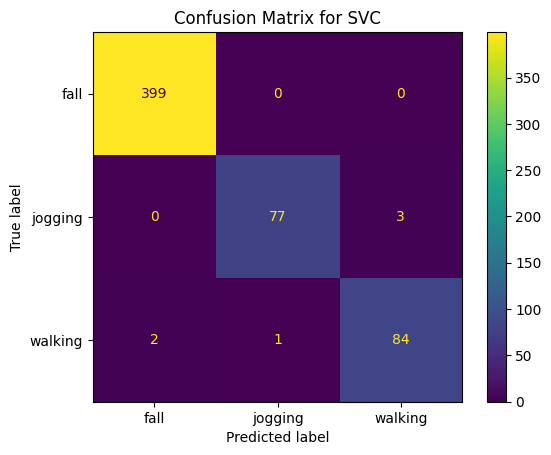

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       1.00      1.00      1.00       399
     jogging       0.97      0.97      0.97        80
     walking       0.98      0.99      0.98        87

    accuracy                           0.99       566
   macro avg       0.98      0.99      0.99       566
weighted avg       0.99      0.99      0.99       566

Confusion Matrix:
Accuracy: 0.9929



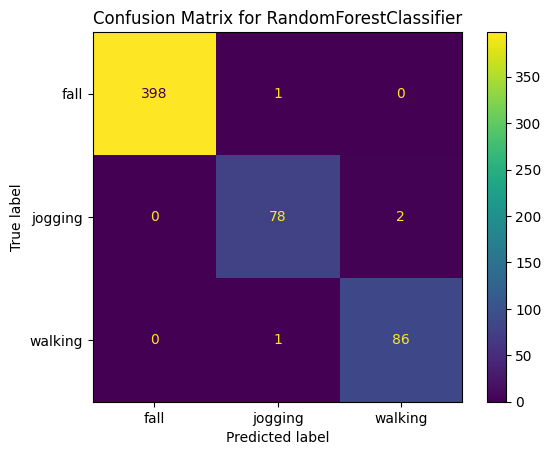

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.99      1.00      1.00       399
     jogging       1.00      0.95      0.97        80
     walking       0.97      0.97      0.97        87

    accuracy                           0.99       566
   macro avg       0.99      0.97      0.98       566
weighted avg       0.99      0.99      0.99       566

Confusion Matrix:
Accuracy: 0.9876



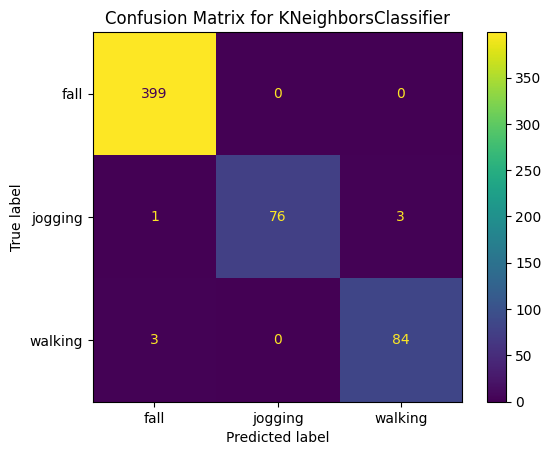

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       1.00      0.99      0.99       399
     jogging       0.96      0.97      0.97        80
     walking       0.96      0.98      0.97        87

    accuracy                           0.99       566
   macro avg       0.97      0.98      0.98       566
weighted avg       0.99      0.99      0.99       566

Confusion Matrix:
Accuracy: 0.9859



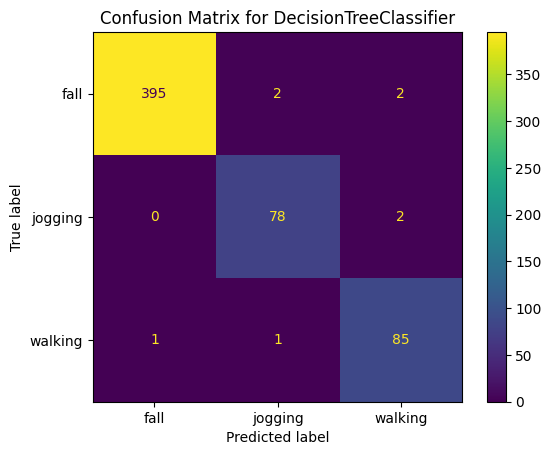

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

        fall       1.00      1.00      1.00       399
     jogging       0.99      0.96      0.97        80
     walking       0.97      0.97      0.97        87

    accuracy                           0.99       566
   macro avg       0.98      0.98      0.98       566
weighted avg       0.99      0.99      0.99       566

Confusion Matrix:
Accuracy: 0.9894



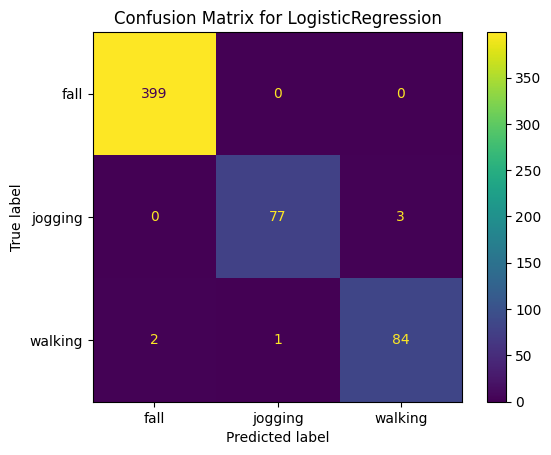

Model: MLPClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       1.00      1.00      1.00       399
     jogging       0.99      0.97      0.98        80
     walking       0.98      0.98      0.98        87

    accuracy                           0.99       566
   macro avg       0.99      0.98      0.99       566
weighted avg       0.99      0.99      0.99       566

Confusion Matrix:
Accuracy: 0.9929



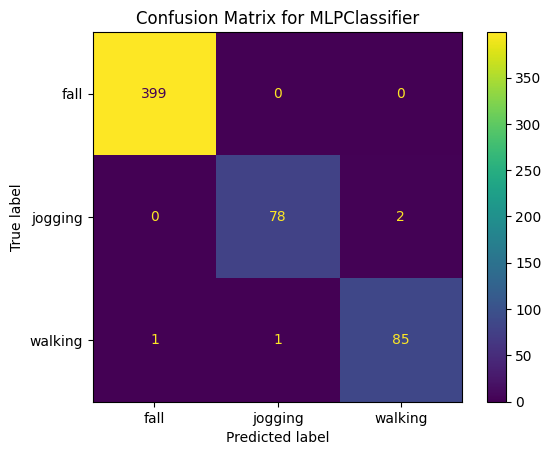

In [76]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, final_X_test, y_test)
evaluate_model(rf, final_X_test, y_test)
evaluate_model(knn, final_X_test, y_test)
evaluate_model(dt, final_X_test, y_test)
evaluate_model(lr, final_X_test, y_test)
evaluate_model(mlp, final_X_test, y_test)

In [66]:
earpiece_raw_dataset

feature_list = []
class_labels = []
for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    features = extract_features_advanced(data, True)
    feature_list.append(features)
    class_labels.append(earpiece_raw_dataset['class'][i])
    prepared_earpiece_dataset = pd.concat(feature_list, ignore_index=True)


# selected_features_earpiece = ['std_acc_y', 'std_mag_acc', 'centile25_mag_acc', 'centile75_mag_acc', 
#                      'C5_trunk_orientation', 'C9_std_magnitude', 'C12_activity_signal_area', 
#                      'C13_horizontal_activity_area', 'mean_acc_y', 'var_acc_y', 
#                      'centile25_acc_y', 'C3_max_peak_to_peak', 'C4_z_axis_vertical_angle']


# prepared_earpiece_dataset = prepared_earpiece_dataset[selected_features_earpiece]

In [67]:

prepared_earpiece_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,C5_trunk_orientation,C6_horizontal_orientation_change,C7_jerk,C8_std_horizontal,C9_std_magnitude,C10_signal_magnitude_area,C11_horizontal_signal_area,C12_activity_signal_area,C13_horizontal_activity_area,C14_velocity_approx
0,-0.814437,0.546556,-0.133941,1.012872,0.012891,0.018413,0.026289,0.011655,0.113540,0.135695,...,0.998699,0.671229,0.011811,0.197941,0.239987,1.536039,0.989482,7885.211380,6553.161076,0.478425
1,-0.583608,0.596157,-0.490585,1.010749,0.070467,0.046796,0.043037,0.075362,0.265456,0.216323,...,0.949889,0.401844,0.015467,0.336903,0.400374,1.677570,1.081362,21832.171963,17227.954206,0.441232
2,-0.892698,0.126547,0.332406,1.020349,0.039711,0.074712,0.050111,0.046841,0.199277,0.273336,...,1.338470,0.816236,0.024597,0.299703,0.405629,1.474146,1.237876,20406.979359,19540.957151,0.547175
3,-0.632372,0.530408,-0.497541,1.014100,0.080119,0.052813,0.061828,0.095134,0.283052,0.229812,...,1.032532,0.467309,0.017285,0.376758,0.441316,1.663922,1.133438,4644.579437,3868.019194,0.456432
4,0.187115,0.391926,-0.874793,1.001327,0.030326,0.018197,0.008908,0.008656,0.174144,0.134896,...,1.164700,0.061151,0.009209,0.198075,0.239647,1.467680,1.073696,3504.644628,3185.846612,0.514193
5,-0.580953,0.511494,-0.574319,1.005525,0.038374,0.026015,0.025267,0.007551,0.195894,0.161292,...,1.031663,0.371714,0.010428,0.252272,0.299427,1.675919,1.164426,3167.403128,2669.917085,0.477216
6,-0.877384,0.444911,-0.134251,1.013555,0.019207,0.027138,0.019952,0.024776,0.138590,0.164736,...,1.114853,0.779915,0.015154,0.197887,0.257483,1.481354,1.035384,5473.194470,4852.987561,0.507675
7,0.624097,0.325314,-0.680792,1.044612,0.304122,0.085627,0.312676,0.570015,0.551472,0.292622,...,1.293614,0.593906,0.045172,0.785365,0.838108,1.694521,1.349601,13961.235149,12999.805701,0.537286
8,-0.561919,0.761735,-0.270332,1.086942,0.294046,0.641398,0.137520,0.860596,0.542261,0.800873,...,0.840869,0.502771,0.060054,0.656937,1.035840,1.720072,0.909610,17608.453234,11247.984696,0.353980
9,-0.283816,0.829115,-0.433044,1.074349,0.130051,0.667537,0.252451,0.851322,0.360626,0.817029,...,0.755198,0.168713,0.039266,0.618467,1.024714,1.652700,0.795863,5908.919614,3376.627164,0.297769


In [68]:
class_labels

['walking',
 'walking',
 'walking',
 'walking',
 'walking',
 'walking',
 'walking',
 'jogging',
 'jogging',
 'jogging']

In [71]:
# First, let's properly prepare the earpiece dataset
feature_list = []
class_labels = []

for i in earpiece_raw_dataset.index:
    data = earpiece_raw_dataset['data'][i]
    features = extract_features(data, True)
    feature_list.append(features)
    class_labels.append(earpiece_raw_dataset['class'][i])

prepared_earpiece_dataset = pd.concat(feature_list, ignore_index=True)

# prepared_earpiece_dataset = prepared_earpiece_dataset[['mean_acc_y', 'mean_mag_acc', 'var_acc_y', 'var_mag_acc', 'std_acc_y', 'std_mag_acc', 'min_mag_acc', 'centile25_mag_acc', 'centile75_acc_y', 'centile75_mag_acc', 'max_acc_y', 'max_mag_acc', 'ptp_acc_y', 'ptp_mag_acc', 'centile25_acc_y', 'ptp_acc_z']]



Random Forest Accuracy: 0.9000
Decision Tree Accuracy: 0.9000
Logistic Regression Accuracy: 0.8000


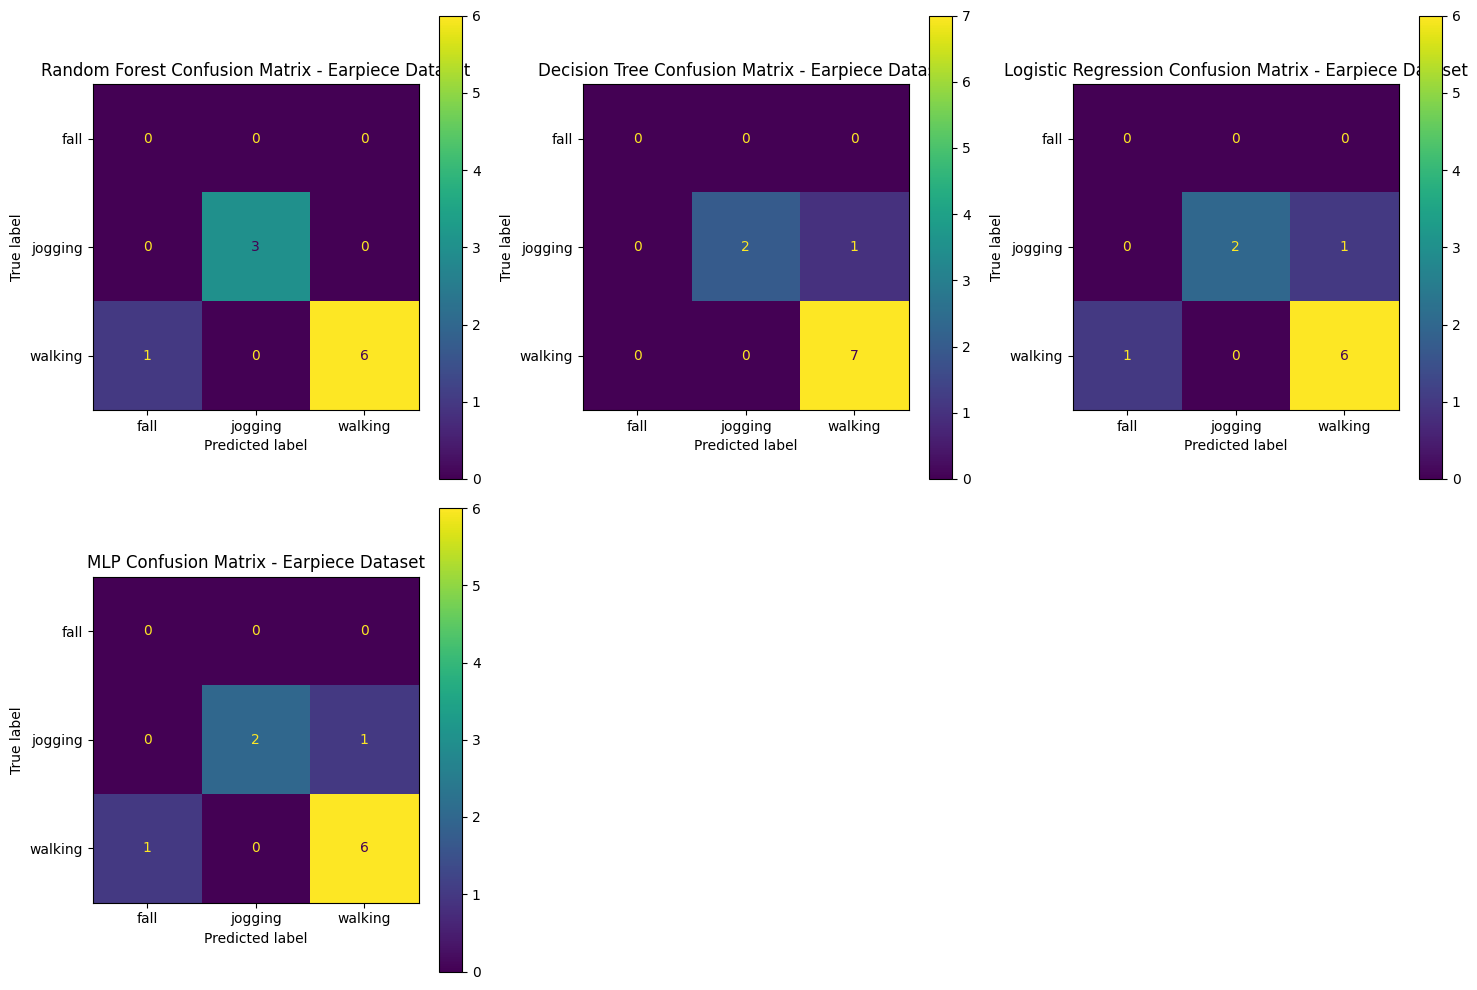

In [77]:
# Make predictions using the trained models
rf_pred = rf.predict(prepared_earpiece_dataset)
dt_pred = dt.predict(prepared_earpiece_dataset)
lr_pred = lr.predict(prepared_earpiece_dataset)
mlp_pred = lr.predict(prepared_earpiece_dataset)

# Print accuracy for each model

print(f"Random Forest Accuracy: {accuracy_score(class_labels, rf_pred):.4f}")
print(f"Decision Tree Accuracy: {accuracy_score(class_labels, dt_pred):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(class_labels, lr_pred):.4f}")

# Create confusion matrices
# The error occurred because the model was trained on 4 classes but the earpiece dataset might have only 3
# We need to ensure the labels are consistent
unique_labels = np.unique(np.concatenate([np.unique(class_labels), np.unique(y_train)]))

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
cm = confusion_matrix(class_labels, rf_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='viridis', ax=plt.gca())
plt.title("Random Forest Confusion Matrix - Earpiece Dataset")


plt.subplot(2, 3, 2)
cm = confusion_matrix(class_labels, dt_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='viridis', ax=plt.gca())
plt.title("Decision Tree Confusion Matrix - Earpiece Dataset")

plt.subplot(2, 3, 3)
cm = confusion_matrix(class_labels, lr_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='viridis', ax=plt.gca())
plt.title("Logistic Regression Confusion Matrix - Earpiece Dataset")

plt.subplot(2, 3, 4)
cm = confusion_matrix(class_labels, mlp_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='viridis', ax=plt.gca())
plt.title("MLP Confusion Matrix - Earpiece Dataset")

plt.tight_layout()
plt.show()